In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import array
from scipy.interpolate import RegularGridInterpolator
import sys
import math

In [3]:
fn      ='/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/historical/r10i1p1f1/Amon/ta/gn/v20190306/ta/ta_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412'
ds     = nc.Dataset(fn)
# ds.append(dsi)
lons	= ds.variables['lon'][:]          #size=1800 #Range is 0.1 .. 359.9
lats	= ds.variables['lat'][:]       #size=400 #Range is -39.9 .. 39.9
# u		= dsi.variables['wind_speed'][:,:,:]    #float wind_speed(time, lat, lon) #units = "m s-1"
time    = ds.variables['time'][:]          #size=24
level   = ds.variables['plev'][:]
# dsi.close

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/collections/cmip/CMIP6/CMIP/CCCma/CanESM5/historical/r10i1p1f1/Amon/ta/gn/v20190306/ta/ta_Amon_CanESM5_historical_r10i1p1f1_gn_185001-201412'

In [31]:
np.shape(level)

(1188, 192, 288)

In [26]:
level[0]

100000.0

In [7]:
lons[-1]

358.75

In [16]:
lats[42]

-50.41884816753927

In [23]:
lats[149]

50.41884816753927

In [27]:
level

masked_array(data=[100000.,  92500.,  85000.,  70000.,  60000.,  50000.,
                    40000.,  30000.,  25000.,  20000.,  15000.,  10000.,
                     7000.,   5000.,   3000.,   2000.,   1000.,    500.,
                      100.],
             mask=False,
       fill_value=1e+20)

In [11]:
np.shape(time)

(1188,)

In [12]:
time[0]

14.5

In [15]:
a =np.arange(9)
print(a)
b = np.reshape(a,(-1,9))

[0 1 2 3 4 5 6 7 8]


In [12]:
print(b[0,0])

0


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap
import cartopy.crs as ccrs
import calendar
import glob

In [2]:
from scipy import stats



In [3]:

cao = []
sw  = []

fi = glob.glob('/glade/work/geethma/research/npzfilesn/cao/2016/M.npz')
fi = np.array(fi)
di = np.load(fi[0])
cao.extend(di['cao'])

fnn = glob.glob('/glade/work/geethma/research/npzfilesn/macsfcwind/2016/m*npz')
fnn = np.array(fnn)

for i in range(0,len(fnn)):
    dd = np.load(fnn[i])
    sw.extend(dd['sfcW'])

print(np.shape(cao))
print(np.shape(sw))






(336, 101, 360)
(336, 101, 360)


In [8]:
d_r = []
for i in range(len(cao)):
    d_r.append(round(cao[i],1))

TypeError: type numpy.ndarray doesn't define __round__ method

In [9]:
cao_r = [np.round(x,1) for x in cao]

In [10]:
sw_r = [np.round(x,1) for x in sw]

In [16]:
cao_rr = cao_r[~np.isnan(cao_r)]

TypeError: only integer scalar arrays can be converted to a scalar index

In [17]:
ii = np.isfinite(cao_r[0])

In [19]:
ind = []
for i in range(len(cao_r)):
    ii = np.isfinite(cao_r)
    ind.extend(ii)
print(np.shape(ind))

(112896, 101, 360)


In [ ]:
print(ind[0:10])

In [13]:
cao_r[0:10]

[array([[-16.3,   nan,   nan, ..., -15.4, -15.8, -16.3],
        [  nan,   nan,   nan, ..., -17.6, -17.3,   nan],
        [  nan,   nan,   nan, ...,   nan, -18.5,   nan],
        ...,
        [-22.8, -22.4, -21.8, ..., -23.9, -23.5, -23.1],
        [-23.5, -23.5, -23.3, ..., -23.3, -23. , -22.3],
        [-24.9, -25.3, -25.3, ..., -24. , -24.2, -24.4]]),
 array([[-10.5, -10.5, -10.1, ..., -10.1, -10.1, -10.3],
        [  nan,   nan,   nan, ..., -12.7, -12. , -11.9],
        [  nan,   nan, -11.4, ..., -13.5, -13.2,   nan],
        ...,
        [-18.1, -18.2, -18.2, ..., -17.9, -17.9, -18.3],
        [-16.6, -16.9, -17.4, ..., -15.4, -15.9, -16.3],
        [  nan,   nan,   nan, ...,   nan,   nan,   nan]]),
 array([[-15.2, -13.7, -12.4, ..., -17. , -16.9, -16.2],
        [  nan,   nan,   nan, ..., -19.6, -18. , -17.9],
        [  nan,   nan, -15.7, ..., -18.8, -18.4,   nan],
        ...,
        [-17.3, -17.9, -18.6, ..., -16.2, -16.6, -17. ],
        [  nan,   nan, -16. , ...,   nan, -13

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/matplotlib/axes/_axes.py:4720: RuntimeWarning: invalid value encountered in less
  bdist = (d1 < d2)


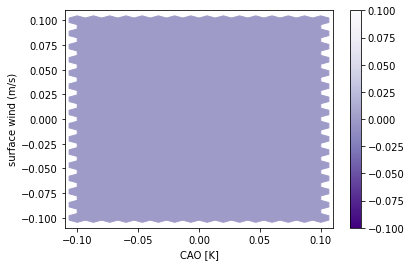

In [11]:
fig = plt.figure()

plt.hexbin(cao_r[:], sw_r[:], gridsize=(15,15), cmap=plt.cm.Purples_r )
plt.xlabel('CAO [K]')
plt.ylabel('surface wind (m/s)')
plt.colorbar()

plt.show()



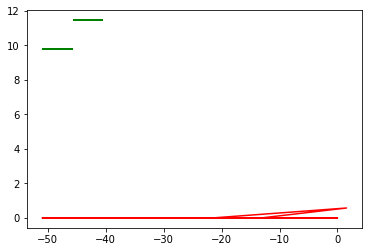

In [20]:
c =[]
w =[]

for i in range(336):
    for j in range(101):
        for k in range(360):
            if  np.isnan(cao[i][j][k])==False & np.isnan(sw[i][j][k])==False:
                c.append(cao[i][j][k])
                w.append(sw[i][j][k])
bin_means, bin_edges, binnumber = stats.binned_statistic(c, w, statistic='mean')

fig = plt.figure()
plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,label='binned statistic of data')
plt.plot(c, x_pdf, 'r-', label='analytical pdf')
# plt.hist(w, bins=50, normed=True, histtype='stepfilled',alpha=0.2, label='histogram of data')
plt.show()

In [17]:
x_pdf = stats.maxwell.pdf(c)

In [ ]:
plt.hist(w, bins=50, normed=True, histtype='stepfilled',alpha=0.2, label='histogram of data')